# Desafio Individual - Visão Computacional  
### Amanda Arruda Melo Silva  
**Ligia - Processo Seletivo 2026**

# 0. Setup

In [ ]:
!pip install -q timm albumentations==1.4.6 opencv-python-headless imagehash grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.5/153.5 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 38.9 MB/s eta 0:00:00


In [ ]:
import os, hashlib, warnings, math
from pathlib import Path
from collections import defaultdict
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import cv2
from PIL import Image
import imagehash
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,
                              brier_score_loss, ConfusionMatrixDisplay)
from sklearn.calibration import calibration_curve

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')


Device: cuda


# 1. Paths e leitura dos CSVs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_PATH       = Path('/content/drive/MyDrive/ligia-compviz')
TRAIN_CSV       = BASE_PATH / 'train.csv'
TEST_CSV        = BASE_PATH / 'test.csv'
TRAIN_NORMAL    = BASE_PATH / 'train' / 'train' / 'NORMAL'
TRAIN_PNEUMONIA = BASE_PATH / 'train' / 'train' / 'PNEUMONIA'
TEST_IMAGES     = BASE_PATH / 'test_images' / 'test_images'
MODELS_DIR      = Path('models')
MODELS_DIR.mkdir(exist_ok=True)

train_raw = pd.read_csv(TRAIN_CSV)
test_df   = pd.read_csv(TEST_CSV)

def build_train_paths(df):
    df = df.copy()
    df['filepath'] = df.apply(
        lambda r: str(TRAIN_NORMAL / r['id']) if r['label'] == 0
                  else str(TRAIN_PNEUMONIA / r['id']), axis=1)
    df['class'] = df['label'].map({0: 'NORMAL', 1: 'PNEUMONIA'})
    return df

train_raw = build_train_paths(train_raw)
test_df['filepath'] = test_df['id'].apply(lambda x: str(TEST_IMAGES / x))

print(f"Train shape: {train_raw.shape}")
print(f"Test  shape: {test_df.shape}")
display(train_raw.head(3))


Train shape: (5232, 4)
Test  shape: (624, 2)


id  label  \
0  NORMAL-8648239-0004.jpeg      0   
1   NORMAL-388586-0003.jpeg      0   
2  NORMAL-7824011-0001.jpeg      0   

                                            filepath   class  
0  /content/drive/MyDrive/ligia-compviz/train/tra...  NORMAL  
1  /content/drive/MyDrive/ligia-compviz/train/tra...  NORMAL  
2  /content/drive/MyDrive/ligia-compviz/train/tra...  NORMAL

# 2. EDA - Análise Exploratória dos Dados

NORMAL: 1349 | PNEUMONIA: 3883 | Razão: 2.88x


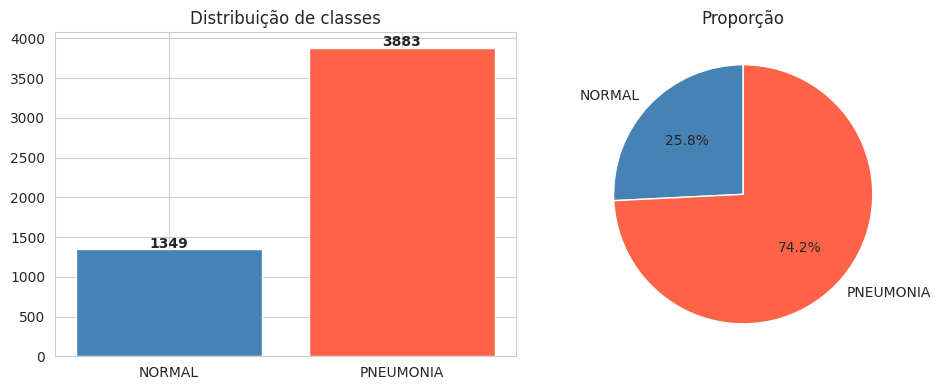

In [ ]:
# Distribuição de classes
class_counts = train_raw['label'].value_counts().sort_index()
ratio = class_counts.max() / class_counts.min()
print(f"NORMAL: {class_counts[0]} | PNEUMONIA: {class_counts[1]} | Razão: {ratio:.2f}x")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].bar(['NORMAL','PNEUMONIA'], class_counts.values, color=['steelblue','tomato'])
axes[0].set_title('Distribuição de classes')
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 20, str(v), ha='center', fontweight='bold')
axes[1].pie(class_counts.values, labels=['NORMAL','PNEUMONIA'],
            autopct='%1.1f%%', startangle=90, colors=['steelblue','tomato'])
axes[1].set_title('Proporção')
plt.tight_layout(); plt.show()


Há um certo desbalanceamento

Train stats:


height   width   mean    std
count   400.0   400.0  400.0  400.0
mean    996.9  1345.9  122.7   57.1
std     411.0   378.2   18.5    9.2
min     144.0   437.0   64.8   26.9
25%     694.0  1072.0  111.7   51.1
50%     928.0  1311.0  123.4   57.8
75%    1200.0  1568.0  134.7   63.3
max    2601.0  2772.0  167.5   80.2

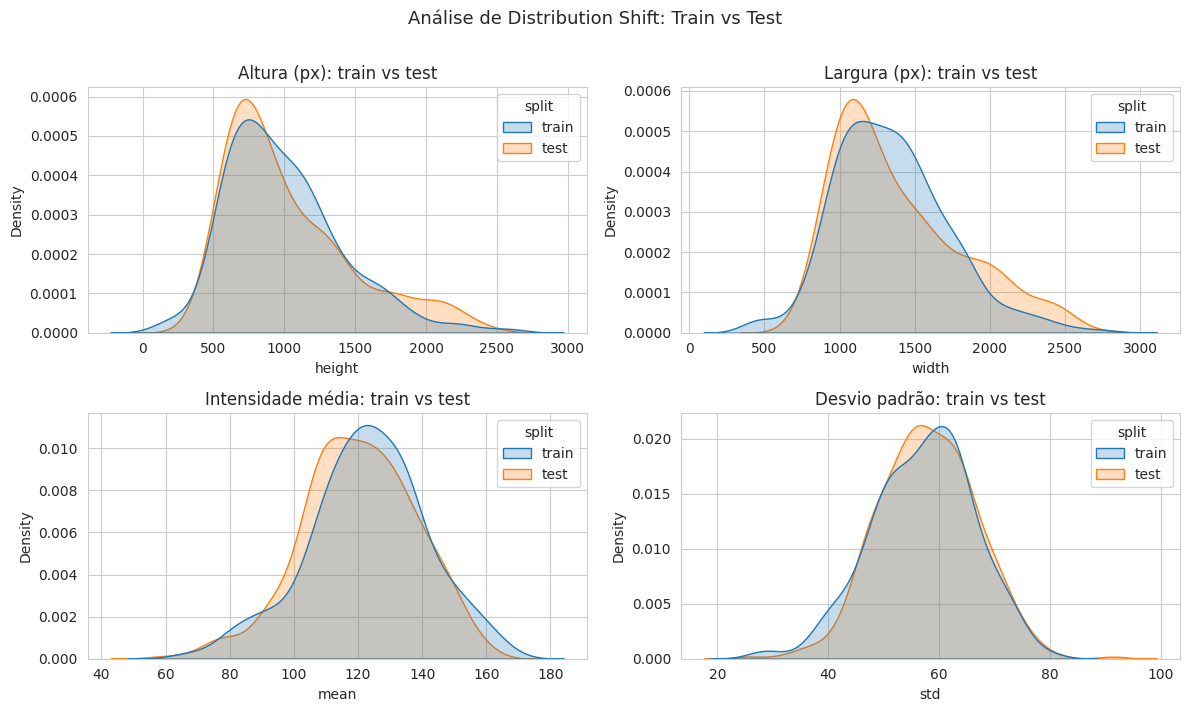

In [ ]:
# Estatísticas de imagem (amostra)
def sample_image_stats(df, n=400, seed=42):
    rows = []
    for fp in df.sample(min(n, len(df)), random_state=seed)['filepath']:
        img = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
        if img is None: continue
        h, w = img.shape
        rows.append({'filepath': fp, 'height': h, 'width': w,
                     'mean': float(img.mean()), 'std': float(img.std())})
    return pd.DataFrame(rows)

# Estatísticas para treino e teste
train_stats = sample_image_stats(train_raw)
test_stats  = sample_image_stats(test_df)
print("Train stats:"); display(train_stats.describe().round(1))

# Combinação para comparação entre splits
comb = pd.concat([train_stats.assign(split='train'),
                  test_stats.assign(split='test')], ignore_index=True)

# Visualização comparativa (KDE)
fig, axes = plt.subplots(2, 2, figsize=(12, 7))
for ax, col, title in zip(axes.flat,
                           ['height','width','mean','std'],
                           ['Altura (px)','Largura (px)','Intensidade média','Desvio padrão']):
    sns.kdeplot(data=comb, x=col, hue='split', fill=True, ax=ax)
    ax.set_title(f'{title}: train vs test')
plt.suptitle('Análise de Distribution Shift: Train vs Test', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()


Não temos um distribution shift relevante entre treino e teste nessa amostra. Isso sugere consistência dos dados.

# 3. Deduplicação: MD5 exato + pHash (near-duplicates)

Vamos checar se tem duplicatas iguais ou próximas. Também queremos fazer isso pra verificar se temos leakage entre treino e teste e pra evitar overfitting, gerando maior capacidade de generalização.

Vamos usar duas abordagens complementares:

- MD5 (Message Digest 5):
    Uma função hash criptográfica que gera uma "assinatura" única do arquivo.
    Se dois arquivos possuem o mesmo MD5, eles são idênticos byte a byte, o que significa que são totalmente iguais.

- pHash (Perceptual Hash):
    Um hash perceptual baseado no conteúdo visual da imagem. Ele permite detectar imagens visualmente semelhantes,
    mesmo que não sejam idênticas em nível de arquivo.

Primeiro removemos duplicatas exatas (MD5).
Depois removemos near-duplicates usando pHash.

In [ ]:
# Hash MD5
def md5_file(path):
    h = hashlib.md5()
    with open(path, 'rb') as f:
        for chunk in iter(lambda: f.read(1 << 20), b''):
            h.update(chunk)
    return h.hexdigest()

# pHash
def compute_phash(path, hash_size=8):
    try:
        return str(imagehash.phash(Image.open(path), hash_size=hash_size))
    except Exception:
        return None

print("Calculando MD5")
train_raw['md5'] = [md5_file(p) for p in tqdm(train_raw['filepath'], desc='MD5')]

# Nível 1: duplicatas exatas
n_before = len(train_raw)
train_dedup1 = train_raw.drop_duplicates(subset='md5', keep='first').reset_index(drop=True)
print(f"\nNível 1 (MD5): {n_before} → {len(train_dedup1)} "
      f"(removidas: {n_before - len(train_dedup1)})")

# Nível 2: near-duplicates
print("\nCalculando pHash...")
train_dedup1['phash'] = [compute_phash(p) for p in tqdm(train_dedup1['filepath'], desc='pHash')]
train_dedup1 = train_dedup1.dropna(subset=['phash']).reset_index(drop=True)

HAMMING_THRESHOLD = 4 # Similaridade máxima permitida
hash_objs = [imagehash.hex_to_hash(h) for h in train_dedup1['phash']]

# Union-Find para clusters
parent = list(range(len(train_dedup1)))
def find(x):
    while parent[x] != x:
        parent[x] = parent[parent[x]]
        x = parent[x]
    return x
def union(a, b):
    pa, pb = find(a), find(b)
    if pa != pb: parent[pa] = pb

# Comparação par a par usando distância de Hamming
print("Calculando near-duplicate")
for i in tqdm(range(len(hash_objs)), desc='pHash cluster'):
    for j in range(i+1, len(hash_objs)):
        if (hash_objs[i] - hash_objs[j]) <= HAMMING_THRESHOLD:
            union(i, j)

# Atribui group_id (raiz do cluster)
train_dedup1['group_id'] = [find(i) for i in range(len(train_dedup1))]

# Mantém apenas 1 imagem por cluster
n_before2 = len(train_dedup1)
train_dedup2 = train_dedup1.groupby('group_id').first().reset_index(drop=False)
train_dedup2 = train_dedup2.rename(columns={'group_id': '_gid_tmp'})
train_dedup2 = train_dedup1.drop_duplicates(subset='group_id', keep='first').reset_index(drop=True)

print(f"Nível 2 (pHash Hamming≤{HAMMING_THRESHOLD}): {n_before2} → {len(train_dedup2)} "
      f"(removidas: {n_before2 - len(train_dedup2)})")
print(f"\nDataset final após deduplicação: {len(train_dedup2)} imagens")
print(f"   Distribuição: {train_dedup2['label'].value_counts().to_dict()}")

# Verificação de vazamento entre treino e teste
print("\nVerificando MD5 train vs test...")
test_df['md5'] = [md5_file(p) for p in tqdm(test_df['filepath'], desc='MD5 test')]
overlap = set(train_dedup2['md5']) & set(test_df['md5'])
print(f"Overlap train↔test (MD5 exato): {len(overlap)}")


Calculando MD5


MD5:   0%|          | 0/5232 [00:00<?, ?it/s]


Nível 1 (MD5): 5232 → 5206 (removidas: 26)

Calculando pHash...


pHash:   0%|          | 0/5206 [00:00<?, ?it/s]

Calculando near-duplicate


pHash cluster:   0%|          | 0/5206 [00:00<?, ?it/s]

Nível 2 (pHash Hamming≤4): 5206 → 5033 (removidas: 173)

Dataset final após deduplicação: 5033 imagens
   Distribuição: {1: 3816, 0: 1217}

Verificando MD5 train vs test...


MD5 test:   0%|          | 0/624 [00:00<?, ?it/s]

Overlap train↔test (MD5 exato): 0


Após a deduplicação (MD5 + pHash), o dataset foi reduzido para 5033 imagens, sem qualquer sobreposição exata entre treino e teste, garantindo maior integridade experimental e ausência de leakage estrutural.

# 4. StratifiedGroupKFold

Vamos usar essa estratégia de validação cruzada porque ela combina dois critérios importantes:

- **Estratificação**: mantém proporções semelhantes das classes (NORMAL e PNEUMONIA) em cada fold.
- **Agrupamento**: impede que imagens pertencentes ao mesmo group_id sejam divididas entre treino e validação.

Apesar de já termos feito a remoção das duplicatas, como às vezes temos radiografias de um mesmo paciente, vamos utilizá-la pra garantir a evitação desse data leakage acidental.


In [ ]:
N_FOLDS = 5

# Usa o clusters de near-duplicates do pHash como grupo para o GroupKFold
sgkf = StratifiedGroupKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

train_dedup2 = train_dedup2.reset_index(drop=True)
train_dedup2['fold'] = -1 # Inicializa coluna de fold

# Geração dos folds
for fold, (_, val_idx) in enumerate(
    sgkf.split(train_dedup2, train_dedup2['label'], groups=train_dedup2['group_id'])
):
    train_dedup2.loc[val_idx, 'fold'] = fold

# Verificação de integridade: nenhum grupo pode cruzar folds
group_fold = train_dedup2.groupby('group_id')['fold'].nunique()
assert (group_fold > 1).sum() == 0, "ERRO: group_id em múltiplos folds!"
print("Nenhum grupo cruzando folds.")

# Distribuição por fold
fold_dist = (train_dedup2.groupby('fold')['label']
             .value_counts(normalize=True)
             .rename('proporção')
             .reset_index())
print("\nDistribuição de classes por fold:")
display(fold_dist.pivot(index='fold', columns='label', values='proporção').round(3))

fold_sizes = train_dedup2.groupby('fold').size()
print("\nTamanho de cada fold:")
print(fold_sizes.to_string())


Nenhum grupo cruzando folds.

Distribuição de classes por fold:


label      0      1
fold               
0      0.242  0.758
1      0.242  0.758
2      0.243  0.757
3      0.243  0.757
4      0.239  0.761


Tamanho de cada fold:
fold
0    1007
1    1007
2    1006
3    1006
4    1007


# 5. Transformações no treino, validação e TTA

**Data Augmentation no Treino**

Durante o treinamento, apliquei transformações leves para aumentar a variabilidade dos dados e reduzir overfitting.
Optei por augmentations mais conservadores, pois se trata de imagens médicas e transformações agressivas poderiam introduzir padrões não realistas e alterar características anatômicas.

Utilizei:
- Pequenos deslocamentos, rotações e variações de escala;
- Ajustes suaves de brilho e contraste;
- Espelhamento horizontal.

Na validação, removemos augmentations e utilizei apenas:
- Resize
- Normalização

Pra garantir que a métrica vai reflitir o desempenho real do modelo, sem ruído artificial.

Também utilizei o TTA (Test-Time Augmentation) apenas na inferência para gerar múltiplas versões levemente transformadas da mesma imagem
(original, flip horizontal e flip vertical), obter previsões para cada uma
e calcular a média das probabilidades.

Assim, a gente realiza múltiplas previsões sobre versões levemente transformadas da mesma imagem e combina os resultados para obter maior robustez, como num ensemble.


In [ ]:
IMG_SIZE = 256

def get_train_transforms(img_size=IMG_SIZE):
    # Augmentations leves pra não descaracterizar também demais o raio-x
    return A.Compose([
        A.Resize(img_size, img_size),

        # Invariância a espelhamentos horizontais
        A.HorizontalFlip(p=0.5),

        # Deslocamentos, zooms e rotações (mais levinhos)
        A.ShiftScaleRotate(
            shift_limit=0.03,
            scale_limit=0.05,
            rotate_limit=5,
            border_mode=cv2.BORDER_REFLECT_101,
            p=0.5
        ),

        # Variações suaves de iluminação e contraste
        A.RandomBrightnessContrast(
            brightness_limit=0.08,
            contrast_limit=0.08,
            p=0.4
        ),

        # Normalização padrão do ImageNet (porque vamos usar um backbone pré-treinado)
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),

        ToTensorV2(),
    ])


def get_valid_transforms(img_size=IMG_SIZE):
    # Validação sem augmentations para mensurar performance de forma consistente
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])


# TTA leve: original + flip horizontal + flip vertical
TTA_TRANSFORMS = [
    A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]),
    A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=1.0),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]),
    A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.VerticalFlip(p=1.0),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]),
]

print(f"TTA augmentations: {len(TTA_TRANSFORMS)} (original + hflip + vflip)")

TTA augmentations: 3 (original + hflip + vflip)


# 6. Dataset CXR

Vamos implementar essa classe que vai ser responsável por:

- Carregar as imagens a partir do path;
- Aplicar as transformações definidas anteriormente;
- Retornar os dados no formato esperado pelo modelo.

e driar uma classe pra garantir compatibilidade com um backbone pré-treinado, como vamos utilizar.

In [ ]:
class CXRDataset(Dataset):
    def __init__(self, df, transforms=None, train=True):
        # Armazena dataframe e parâmetros
        self.df = df.reset_index(drop=True)
        self.transforms = transforms
        self.train = train

    def __len__(self):
        return len(self.df) # num. de amostras

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv2.imread(row['filepath'], cv2.IMREAD_GRAYSCALE)
        if img is None:
            img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) # converte de escala de cinza pra rgb
        if self.transforms:
            img = self.transforms(image=img)['image'] # aplica transformações
        if self.train:
            return img, torch.tensor(row['label'], dtype=torch.float32)
        return img, row['id']


# 7. Backbone - EfficientNet B0

A EfficientNet é uma família de redes convolucionais que utiliza
um método de compound scaling que escala de uma forma mais equilibrada a
profundidade, largura e resolução da rede.

A versão B0 é a de menor custo computacional mas com boa capacidade de representação. Ela foi escolhida por ter um bom custo benefício entre performance e tempo de treinamento.

In [ ]:
MODEL_NAME = 'tf_efficientnet_b0_ns'

def build_model(model_name=MODEL_NAME, pretrained=True):
    model = timm.create_model(
        model_name,
        pretrained=pretrained,
        in_chans=3,
        num_classes=1
    )
    return model.to(DEVICE)

# Checagem rápida do tamanho do backbone escolhido
m = build_model(MODEL_NAME)
n = sum(p.numel() for p in m.parameters())
print(f"{MODEL_NAME}: {n:,} parâmetros")
del m

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

tf_efficientnet_b0_ns: 4,008,829 parâmetros


# 8. Loop de treinamento

In [ ]:
BATCH_SIZE  = 32
NUM_WORKERS = 4
N_EPOCHS    = 12
EARLY_STOP_PATIENCE = 5

# pos_weight para desbalanceamento (penaliza mais erros na classe positiva/minoritária)
class_counts = train_dedup2['label'].value_counts()
pos_weight_val = class_counts[0] / class_counts[1]
pos_weight = torch.tensor([pos_weight_val], device=DEVICE, dtype=torch.float32)
criterion  = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
print(f"pos_weight = {pos_weight_val:.4f} (penaliza erros na classe minoritária)")

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train() # ativa dropout/batchnorm em modo treino
    total_loss, n = 0.0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.float().to(device)
        logits = model(imgs).squeeze(1)
        loss   = criterion(logits, labels)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        n += imgs.size(0)
    return total_loss / n # loss média por amostra

def validate_epoch(model, loader, criterion, device):
    model.eval() # desativa dropout e fixa batchnorm
    total_loss, n = 0.0, 0
    all_labels, all_probs = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.float().to(device)
            logits = model(imgs).squeeze(1)
            loss   = criterion(logits, labels)
            probs  = torch.sigmoid(logits) # logits -> probabilidade
            total_loss += loss.item() * imgs.size(0)
            n += imgs.size(0)
            all_labels.append(labels.cpu())
            all_probs.append(probs.cpu())
    all_labels = torch.cat(all_labels).numpy()
    all_probs  = torch.cat(all_probs).numpy()
    # ROC AUC
    auc = roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else float('nan')
    return total_loss / n, auc, all_labels, all_probs

def get_fold_loaders(df, fold, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    # separa treino/val pelo índice do fold (mantendo splits definidos anteriormente)
    tr = df[df['fold'] != fold].reset_index(drop=True)
    va = df[df['fold'] == fold].reset_index(drop=True)
    tr_ds = CXRDataset(tr, get_train_transforms(), train=True)
    va_ds = CXRDataset(va, get_valid_transforms(), train=True)
    tr_ld = DataLoader(tr_ds, batch_size=batch_size, shuffle=True,
                       num_workers=num_workers, pin_memory=True)
    va_ld = DataLoader(va_ds, batch_size=batch_size, shuffle=False,
                       num_workers=num_workers, pin_memory=True)
    return tr_ld, va_ld

def run_fold(df, fold, model_name='tf_efficientnet_b0_ns',
             n_epochs=N_EPOCHS, base_lr=1e-3, es_patience=EARLY_STOP_PATIENCE):
    # Treina um fold, retorna histórico e OOF preds.
    tr_ld, va_ld = get_fold_loaders(df, fold)
    model = build_model(model_name, pretrained=True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=1e-4)
    # reduz LR quando o AUC estaciona
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2)

    best_auc, best_state, best_oof = -1.0, None, None
    history = defaultdict(list)
    epochs_no_improve = 0

    for epoch in range(1, n_epochs+1):
        tr_loss = train_one_epoch(model, tr_ld, optimizer, criterion, DEVICE)
        va_loss, va_auc, va_labels, va_probs = validate_epoch(
            model, va_ld, criterion, DEVICE)
        scheduler.step(va_auc)
        lr = optimizer.param_groups[0]['lr']
        history['epoch'].append(epoch)
        history['train_loss'].append(tr_loss)
        history['val_loss'].append(va_loss)
        history['val_auc'].append(va_auc)
        history['lr'].append(lr)
        print(f"  Epoch {epoch:2d}/{n_epochs} | "
              f"train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | "
              f"val_AUC={va_auc:.5f} | lr={lr:.2e}")

        # checkpoint do melhor AUC (para OOF e inferência final)
        if va_auc > best_auc:
            best_auc = va_auc
            best_state = deepcopy(model.state_dict())
            best_oof = (va_labels, va_probs)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= es_patience:
            print(f"  Early stopping. Val AUC não melhorou por {es_patience} épocas.")
            break

    ckpt_path = MODELS_DIR / f'{model_name}_fold{fold}_best.pth'
    torch.save({'model_state_dict': best_state,
                'model_name': model_name, 'fold': fold, 'val_auc': best_auc}, ckpt_path)
    print(f" Fold {fold} best AUC = {best_auc:.5f} | saved: {ckpt_path}")
    return dict(history), best_oof, best_auc

pos_weight = 0.3189 (penaliza erros na classe minoritária)


# 9. Treinamento EfficientNet-B0 em todos os folds

In [ ]:
all_histories = {} # armazena curvas de treino/val por fold
all_oof       = {} # guarda predições OOF: {fold: (labels_reais, probs_preditas)}
fold_aucs     = [] # AUC de cada fold (para média e desvio)

# Loop principal da validação cruzada
for fold in range(N_FOLDS):
    print(f"\n{'='*60}")
    print(f"  {MODEL_NAME} - Fold {fold}/{N_FOLDS-1}")
    print('='*60)

    # retorna:
    # histórico (loss/AUC por época)
    # predições OOF do melhor checkpoint
    # melhor AUC obtida
    hist, oof, best_auc = run_fold(train_dedup2, fold, model_name=MODEL_NAME)

    all_histories[fold] = hist
    all_oof[fold]       = oof
    fold_aucs.append(best_auc)

print(f"\n{'='*60}")
print(f"{MODEL_NAME} - AUC por fold: {[f'{a:.5f}' for a in fold_aucs]}")
print(f"{MODEL_NAME} - AUC média: {np.mean(fold_aucs):.5f} ± {np.std(fold_aucs):.5f}")


  tf_efficientnet_b0_ns - Fold 0/4
  Epoch  1/12 | train_loss=0.1195 | val_loss=0.0719 | val_AUC=0.99745 | lr=1.00e-03
  Epoch  2/12 | train_loss=0.0389 | val_loss=0.0211 | val_AUC=0.99909 | lr=1.00e-03
  Epoch  3/12 | train_loss=0.0264 | val_loss=0.0340 | val_AUC=0.99920 | lr=1.00e-03
  Epoch  4/12 | train_loss=0.0284 | val_loss=0.1453 | val_AUC=0.99829 | lr=1.00e-03
  Epoch  5/12 | train_loss=0.0200 | val_loss=0.0163 | val_AUC=0.99943 | lr=1.00e-03
  Epoch  6/12 | train_loss=0.0305 | val_loss=0.0185 | val_AUC=0.99922 | lr=1.00e-03
  Epoch  7/12 | train_loss=0.0128 | val_loss=0.0189 | val_AUC=0.99937 | lr=1.00e-03
  Epoch  8/12 | train_loss=0.0095 | val_loss=0.0103 | val_AUC=0.99975 | lr=1.00e-03
  Epoch  9/12 | train_loss=0.0061 | val_loss=0.0133 | val_AUC=0.99975 | lr=1.00e-03
  Epoch 10/12 | train_loss=0.0253 | val_loss=0.0576 | val_AUC=0.99830 | lr=1.00e-03
  Epoch 11/12 | train_loss=0.0258 | val_loss=0.0340 | val_AUC=0.99920 | lr=5.00e-04
  Epoch 12/12 | train_loss=0.0095 | val_

# 10. Resumo

In [ ]:
summary_df = pd.DataFrame({
    'fold': list(range(N_FOLDS)),
    'auc': fold_aucs,
})
display(summary_df)

fold       auc
0     0  0.999748
1     1  0.999844
2     2  0.999513
3     3  0.999779
4     4  0.999859

# 11. Curvas de treinamento

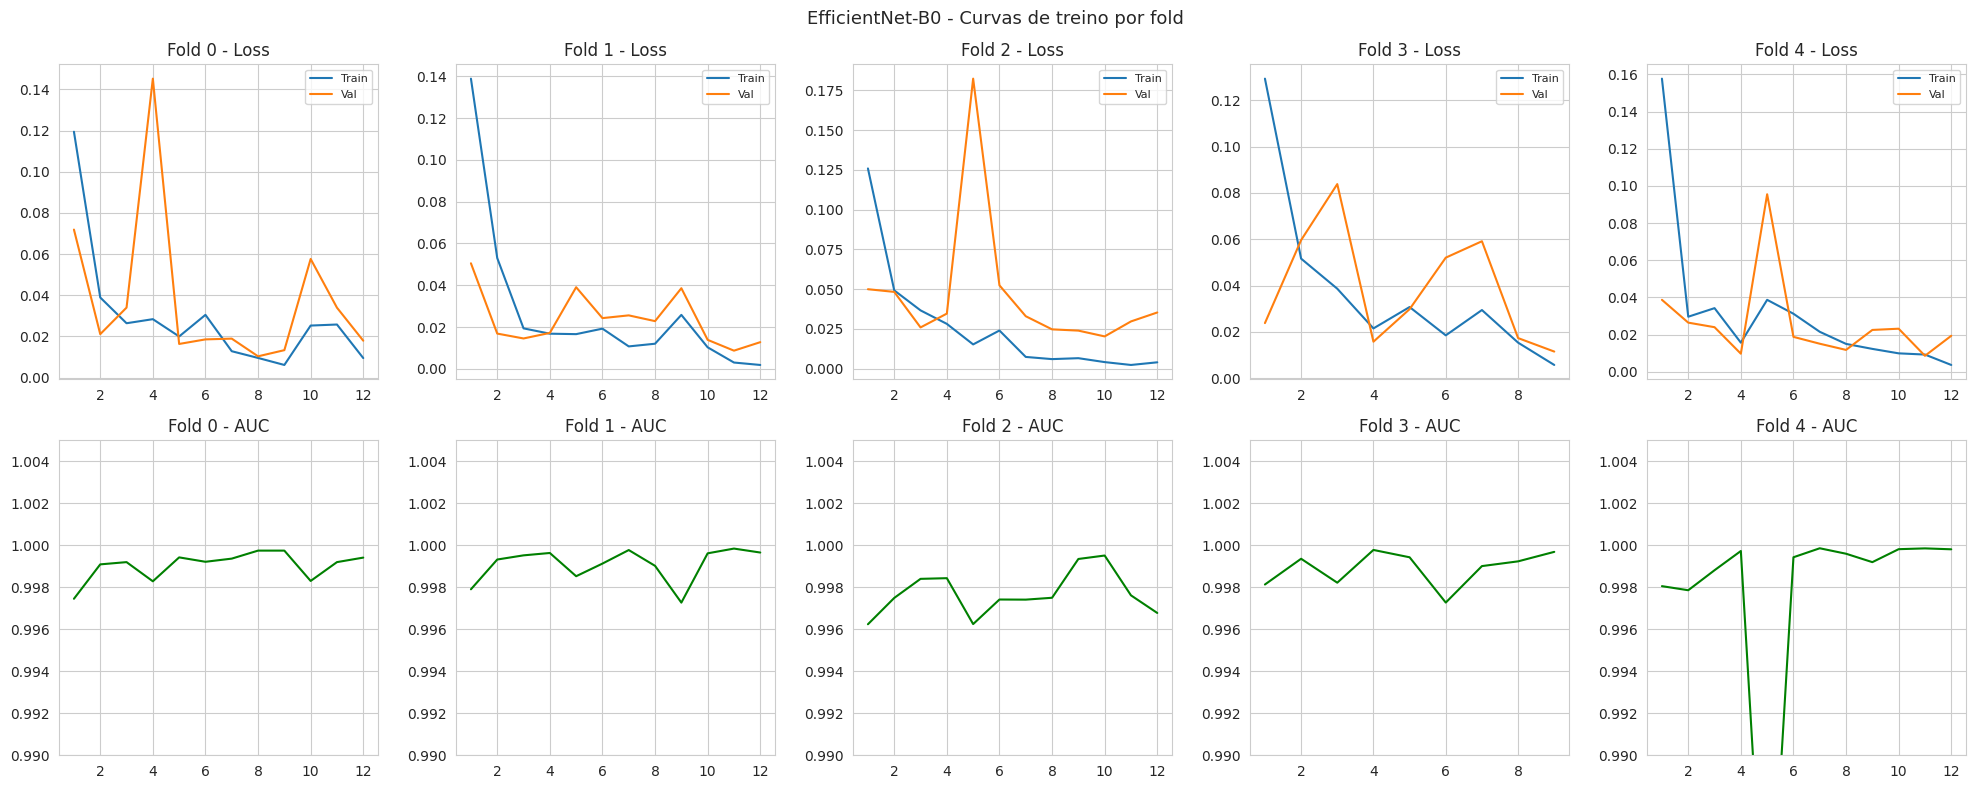

In [ ]:
def plot_all_fold_histories(all_histories, model_name):
    fig, axes = plt.subplots(2, N_FOLDS, figsize=(4*N_FOLDS, 8))
    for fold, hist in all_histories.items():
        epochs = hist['epoch']

        # curvas de loss
        axes[0, fold].plot(epochs, hist['train_loss'], label='Train')
        axes[0, fold].plot(epochs, hist['val_loss'],   label='Val')
        axes[0, fold].set_title(f'Fold {fold} - Loss')
        axes[0, fold].legend(fontsize=8); axes[0, fold].grid(True)

        # curvas de auc
        axes[1, fold].plot(epochs, hist['val_auc'], color='green', label='Val AUC')
        axes[1, fold].set_ylim(0.99, 1.005)
        axes[1, fold].set_title(f'Fold {fold} - AUC')
        axes[1, fold].grid(True)
    plt.suptitle(f'{model_name} - Curvas de treino por fold', fontsize=13)
    plt.tight_layout(); plt.show()

plot_all_fold_histories(all_histories, 'EfficientNet-B0')

# 12. Análise OOF (Out-of-Fold)

A avaliação OOF vai reuninr todas as predições feitas na validação cruzada, considerando apenas amostras que o modelo não viu no treino de cada fold. O modelo é treinado em uma parte dos dados
e avalia apenas amostras que não viu durante o treino.
Ao juntar todas essas predições, obtemos uma estimativa
mais realista do desempenho do modelo.

Além disso, vamos analisar a curva ROC e a Matriz de Confusão.







OOF AUC (tf_efficientnet_b0_ns): 0.99953


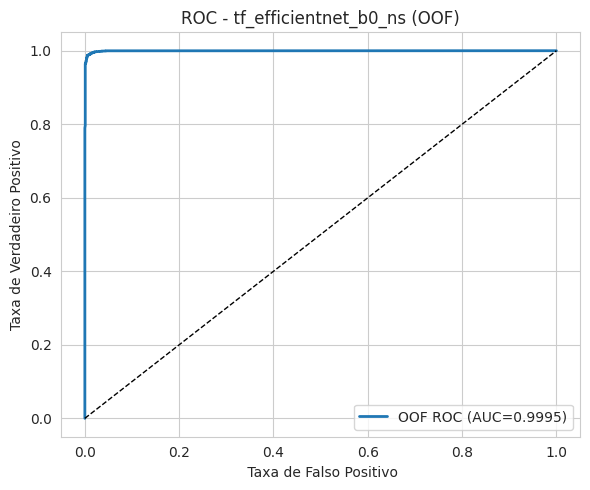

In [ ]:
def aggregate_oof(all_oof):
    # Concatena as predições OOF de todos os folds em arrays únicos de labels e probabilidades
    all_labels = np.concatenate([v[0] for v in all_oof.values()])
    all_probs  = np.concatenate([v[1] for v in all_oof.values()])
    return all_labels, all_probs

oof_labels, oof_probs = aggregate_oof(all_oof)
oof_auc = roc_auc_score(oof_labels, oof_probs)

print(f"OOF AUC ({MODEL_NAME}): {oof_auc:.5f}")

# Curva ROC com IC
fig, ax = plt.subplots(figsize=(6, 5))
fpr, tpr, _ = roc_curve(oof_labels, oof_probs)
ax.plot(fpr, tpr, lw=2, label=f'OOF ROC (AUC={oof_auc:.4f})')
ax.plot([0,1],[0,1], 'k--', lw=1)
ax.set_xlabel(' Taxa de Falso Positivo'); ax.set_ylabel('Taxa de Verdadeiro Positivo')
ax.set_title(f'ROC - {MODEL_NAME} (OOF)')
ax.legend(); ax.grid(True); plt.tight_layout(); plt.show()

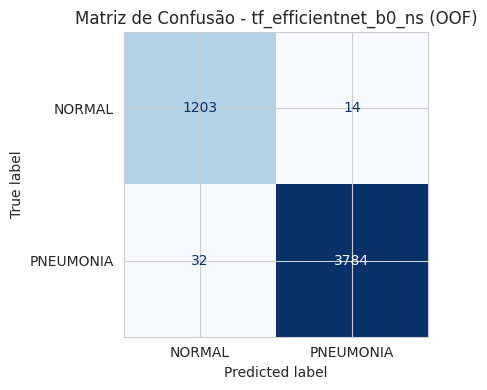

In [ ]:
# Matriz de Confusão (threshold 0.5)
preds = (oof_probs >= 0.5).astype(int)
cm = confusion_matrix(oof_labels, preds)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
disp = ConfusionMatrixDisplay(cm, display_labels=['NORMAL','PNEUMONIA'])
disp.plot(ax=ax, colorbar=False, cmap='Blues')
ax.set_title(f'Matriz de Confusão - {MODEL_NAME} (OOF)')
plt.tight_layout(); plt.show()

# 13. Análise de Erros - FP, FN e baixa confiança

Vamos realizar essa análise qualitativa dos erros do modelo para entendermos como o modelo está errando,
e não apenas quanto ele está acertando. Vamos fazer isso através da análise de Falsos Positivos, Falsos Negativos e casos de baixa confiança, em que o modelo demonstra incerteza.

TP: 3784 | TN: 1203 | FP: 14 | FN: 32
Baixa confiança (0.35–0.65): 24 casos (0.5%)

Accuracy: 0.9909
FP rate (falsos alarmes): 0.0115
FN rate (pneumonias perdidas): 0.0084


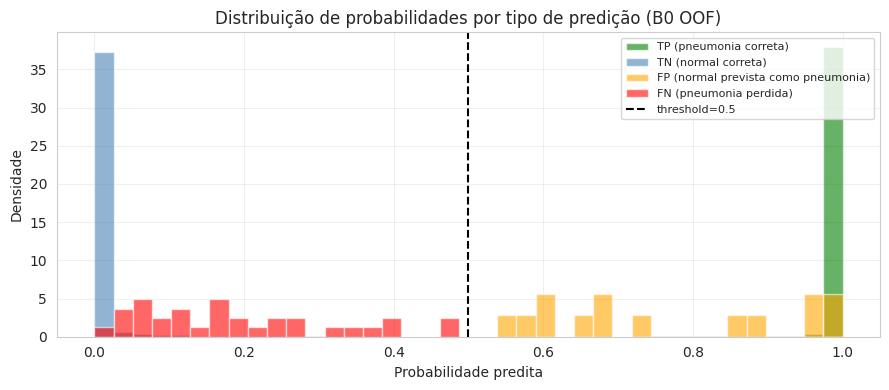

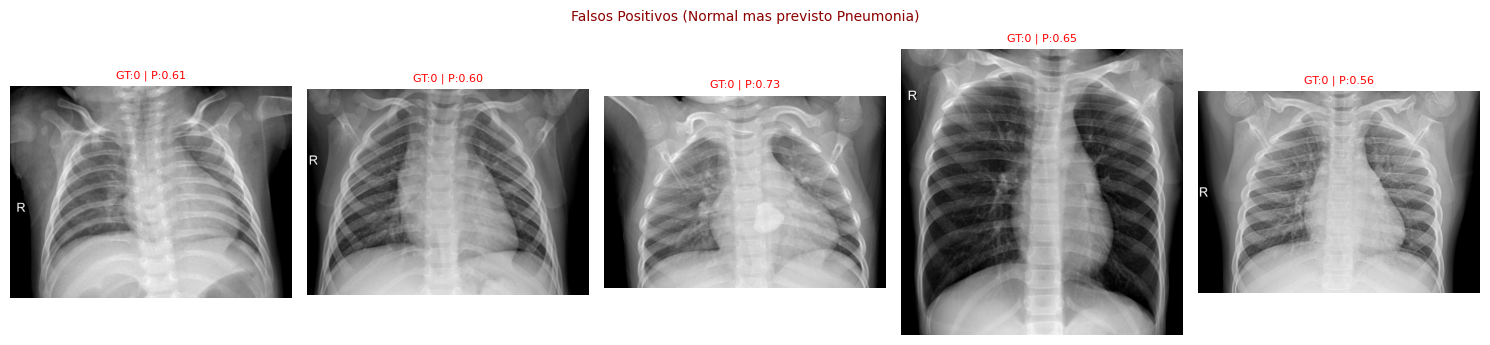

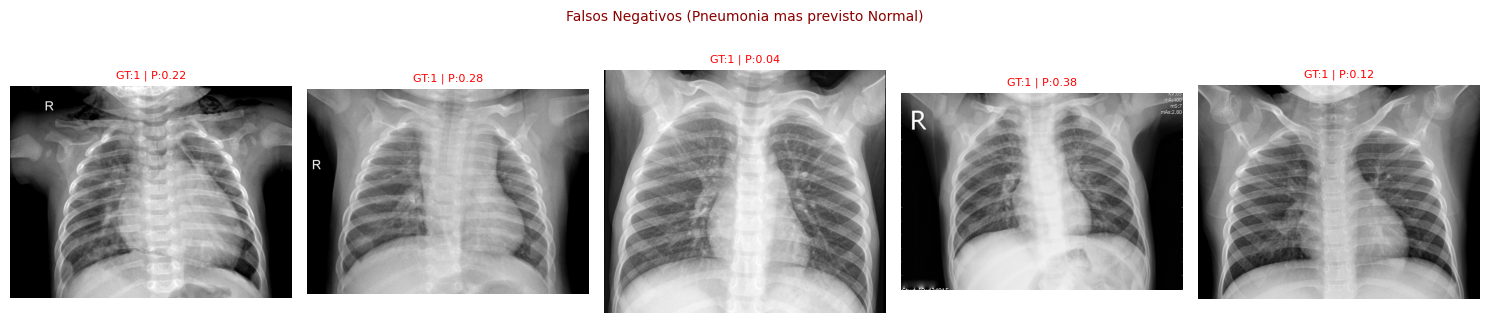

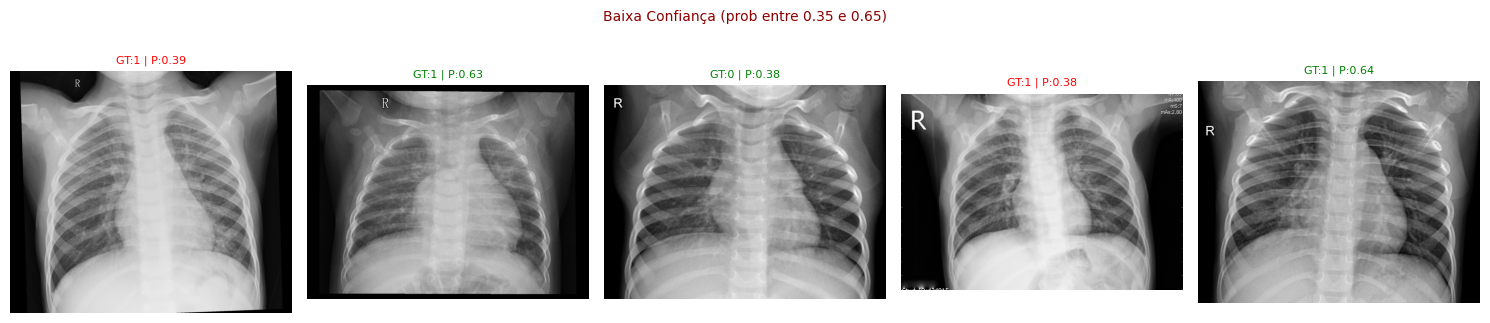

In [ ]:
def collect_oof_with_ids(df, all_oof):
    parts = []
    for fold, (labels, probs) in all_oof.items():
        va_df = df[df['fold'] == fold].reset_index(drop=True).copy()
        va_df['oof_prob'] = probs
        va_df['oof_pred'] = (probs >= 0.5).astype(int)
        va_df['correct']  = (va_df['oof_pred'] == va_df['label'])
        parts.append(va_df)
    return pd.concat(parts, ignore_index=True)

oof_df_b0 = collect_oof_with_ids(train_dedup2, all_oof)

# Categorias de erro
TP_df = oof_df_b0[(oof_df_b0['label']==1) & (oof_df_b0['oof_pred']==1)]
TN_df = oof_df_b0[(oof_df_b0['label']==0) & (oof_df_b0['oof_pred']==0)]
FP_df = oof_df_b0[(oof_df_b0['label']==0) & (oof_df_b0['oof_pred']==1)]
FN_df = oof_df_b0[(oof_df_b0['label']==1) & (oof_df_b0['oof_pred']==0)]
LC_df = oof_df_b0[oof_df_b0['oof_prob'].between(0.35, 0.65)]  # baixa confiança

print(f"TP: {len(TP_df)} | TN: {len(TN_df)} | FP: {len(FP_df)} | FN: {len(FN_df)}")
print(f"Baixa confiança (0.35–0.65): {len(LC_df)} casos ({100*len(LC_df)/len(oof_df_b0):.1f}%)")
print(f"\nAccuracy: {oof_df_b0['correct'].mean():.4f}")
print(f"FP rate (falsos alarmes): {len(FP_df) / (len(FP_df)+len(TN_df)):.4f}")
print(f"FN rate (pneumonias perdidas): {len(FN_df) / (len(FN_df)+len(TP_df)):.4f}")

# Distribuição de probabilidades por categoria
fig, ax = plt.subplots(figsize=(9, 4))
bins = np.linspace(0, 1, 40)
for data, label, color in [
    (TP_df['oof_prob'], 'TP (pneumonia correta)', 'green'),
    (TN_df['oof_prob'], 'TN (normal correta)',    'steelblue'),
    (FP_df['oof_prob'], 'FP (normal prevista como pneumonia)', 'orange'),
    (FN_df['oof_prob'], 'FN (pneumonia perdida)', 'red'),
]:
    ax.hist(data, bins=bins, alpha=0.6, label=label, color=color, density=True)
ax.axvline(0.5, color='k', ls='--', label='threshold=0.5')
ax.set_xlabel('Probabilidade predita'); ax.set_ylabel('Densidade')
ax.set_title('Distribuição de probabilidades por tipo de predição (B0 OOF)')
ax.legend(fontsize=8); ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# Amostras visuais de FP e FN
def show_error_samples(df, n=5, title='', seed=42):
    sample = df.sample(min(n, len(df)), random_state=seed).reset_index(drop=True)
    if len(sample) == 0:
        print(f"{title}: sem amostras")
        return
    fig, axes = plt.subplots(1, len(sample), figsize=(3*len(sample), 3.5))
    if len(sample) == 1: axes = [axes]
    for ax, (_, row) in zip(axes, sample.iterrows()):
        img = cv2.imread(row['filepath'], cv2.IMREAD_GRAYSCALE)
        ax.imshow(img, cmap='gray')
        ax.set_title(f"GT:{int(row['label'])} | P:{row['oof_prob']:.2f}",
                     fontsize=8, color='red' if not row['correct'] else 'green')
        ax.axis('off')
    plt.suptitle(title, fontsize=10, color='darkred')
    plt.tight_layout(); plt.show()

show_error_samples(FP_df, n=5, title='Falsos Positivos (Normal mas previsto Pneumonia)')
show_error_samples(FN_df, n=5, title='Falsos Negativos (Pneumonia mas previsto Normal)')
show_error_samples(LC_df, n=5, title='Baixa Confiança (prob entre 0.35 e 0.65)')


# 14. Calibração - Brier Score e Reliability Diagram

- Brier Score

Mede o erro quadrático médio entre probabilidade prevista e rótulo real.
Quanto menor, melhor.

- Reliability Diagram

Compara probabilidade média prevista com a fração real de positivos.
Quanto mais próximo da diagonal, melhor calibrado está o modelo.

Brier Score (tf_efficientnet_b0_ns): 0.0070
(0 = perfeito | 0.25 = random)


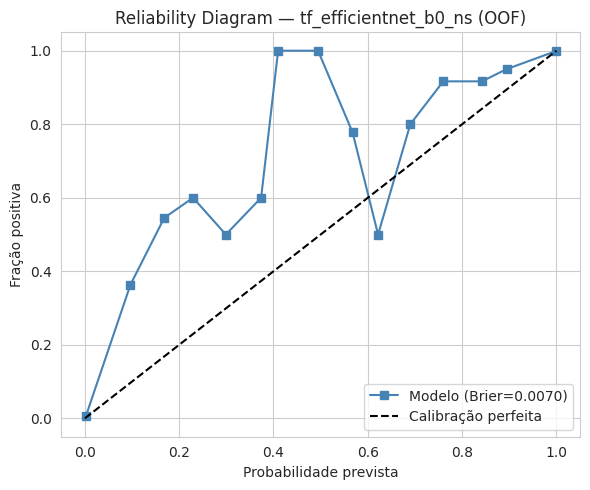

In [ ]:
# Brier Score
brier = brier_score_loss(oof_labels, oof_probs)
print(f"Brier Score ({MODEL_NAME}): {brier:.4f}")
print("(0 = perfeito | 0.25 = random)")

# Reliability Diagram (probabilidade prevista vs frequência real)
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
frac_pos, mean_pred = calibration_curve(oof_labels, oof_probs, n_bins=15, strategy='uniform')
ax.plot(mean_pred, frac_pos, 's-', label=f'Modelo (Brier={brier:.4f})', color='steelblue')
ax.plot([0,1],[0,1], 'k--', label='Calibração perfeita')
ax.set_xlabel('Probabilidade prevista')
ax.set_ylabel('Fração positiva')
ax.set_title(f'Reliability Diagram — {MODEL_NAME} (OOF)')
ax.legend(); ax.grid(True); plt.tight_layout(); plt.show()

# 15. Interpretabilidade - Grad-CAM

Destaca as regiões da imagem que mais influenciaram a decisão do modelo utilizando os gradientes da última camada convolucional para gerar um mapa de ativação,
indicando onde o modelo concentrou sua atenção ao prever pneumonia.

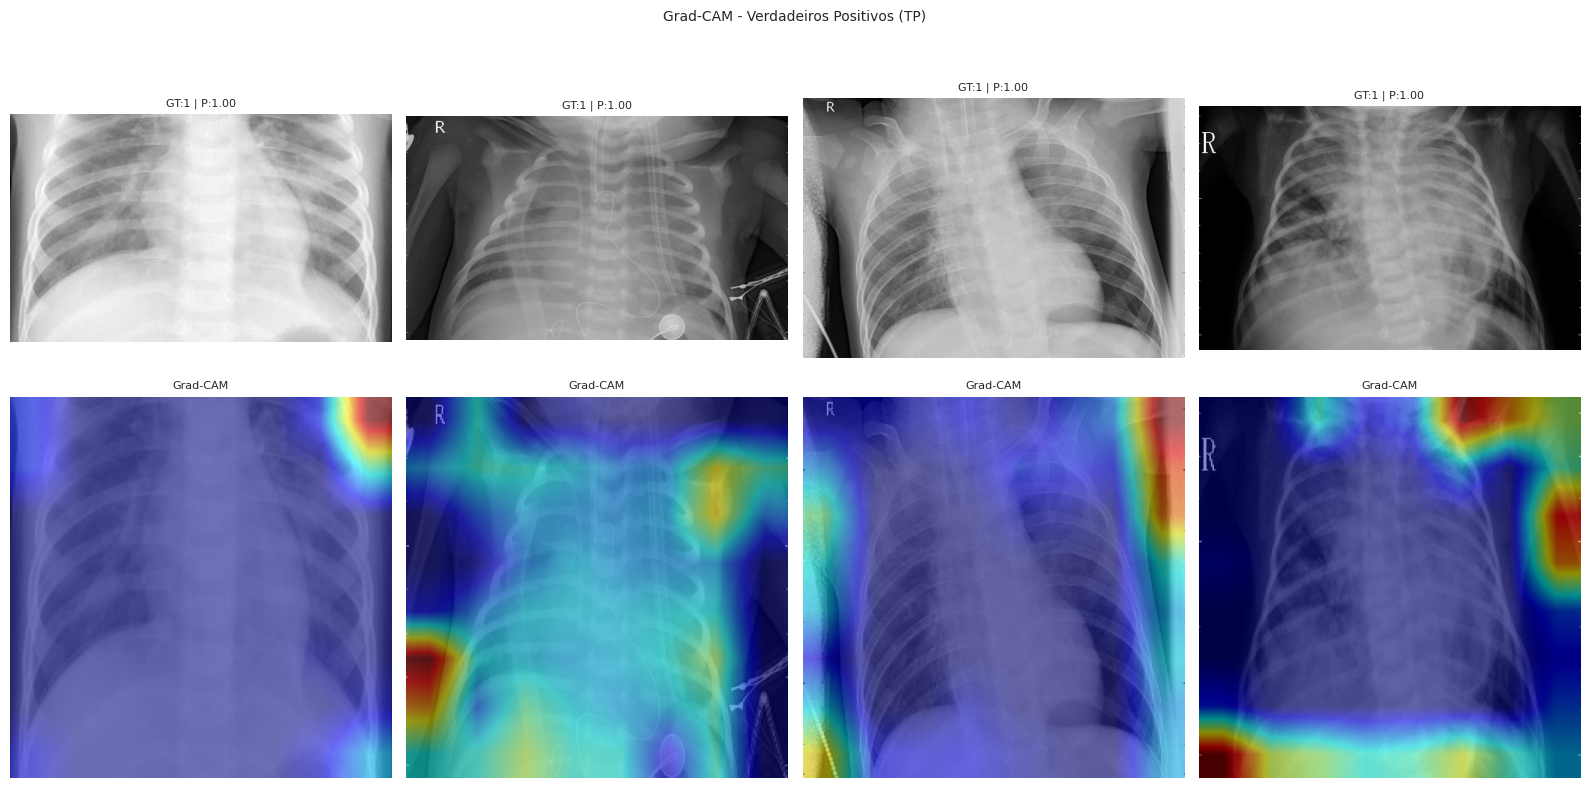

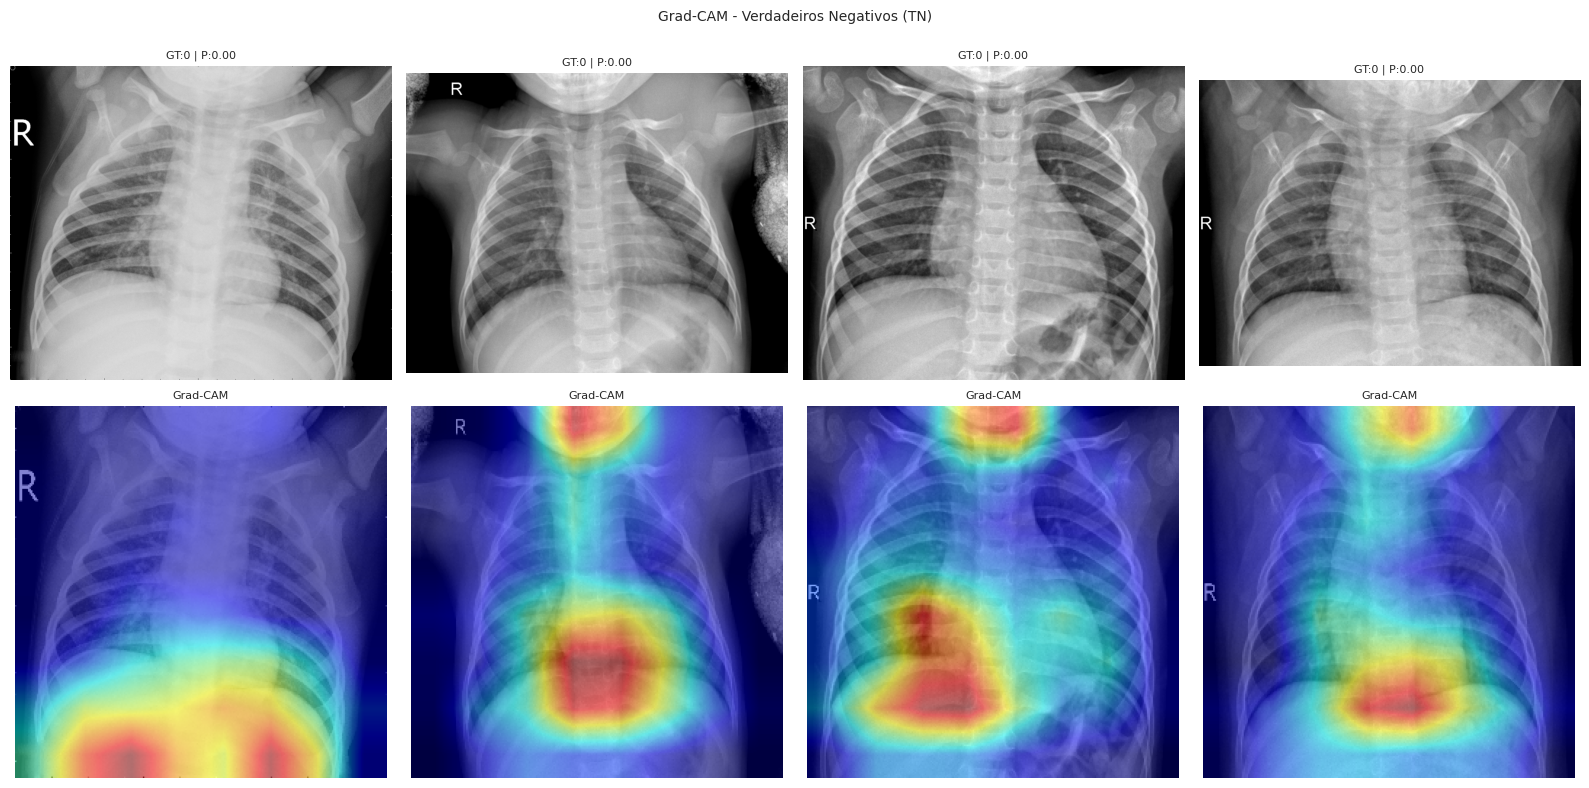

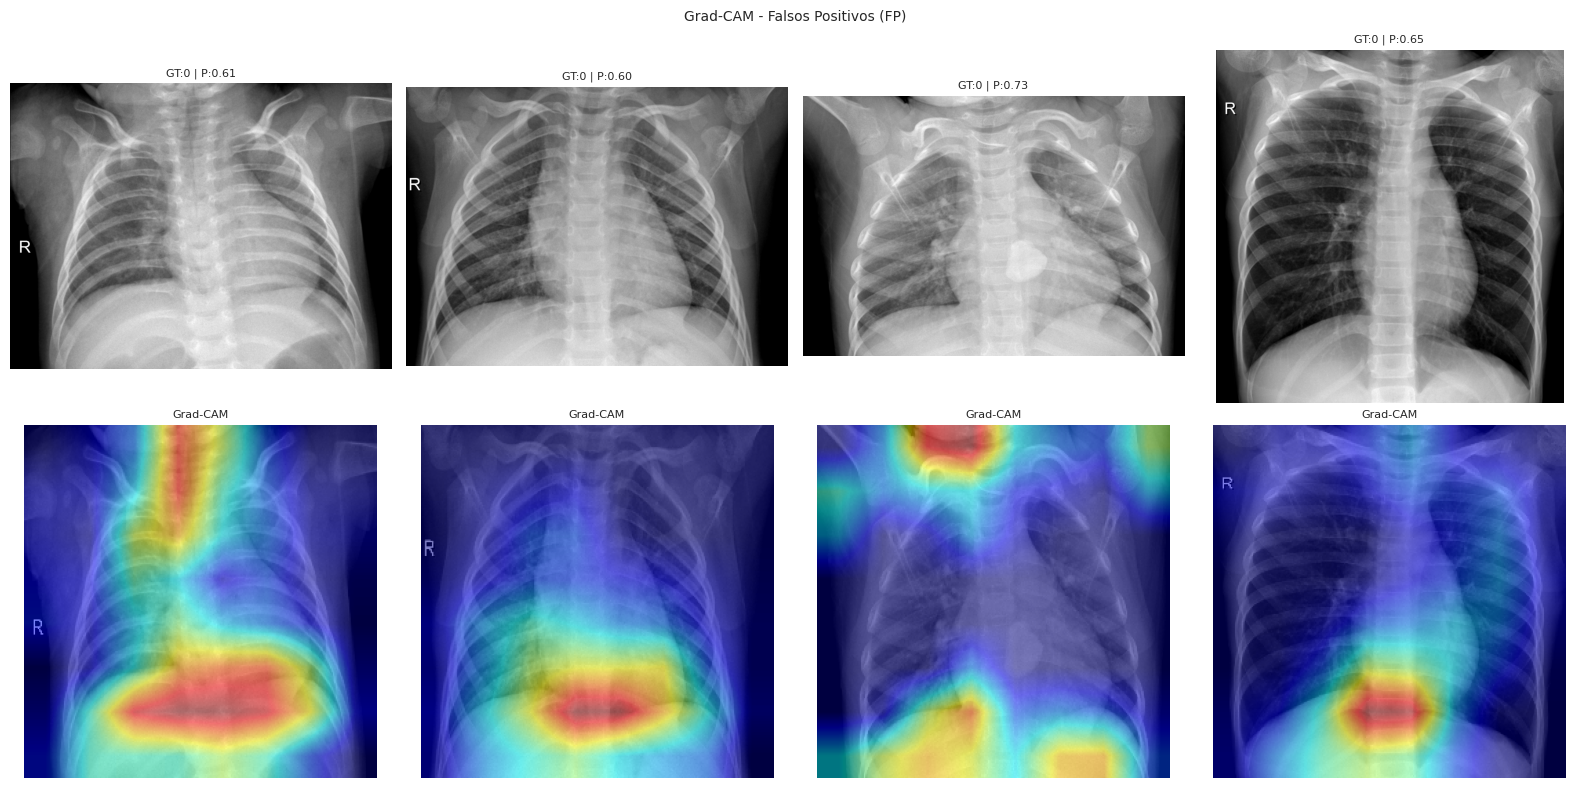

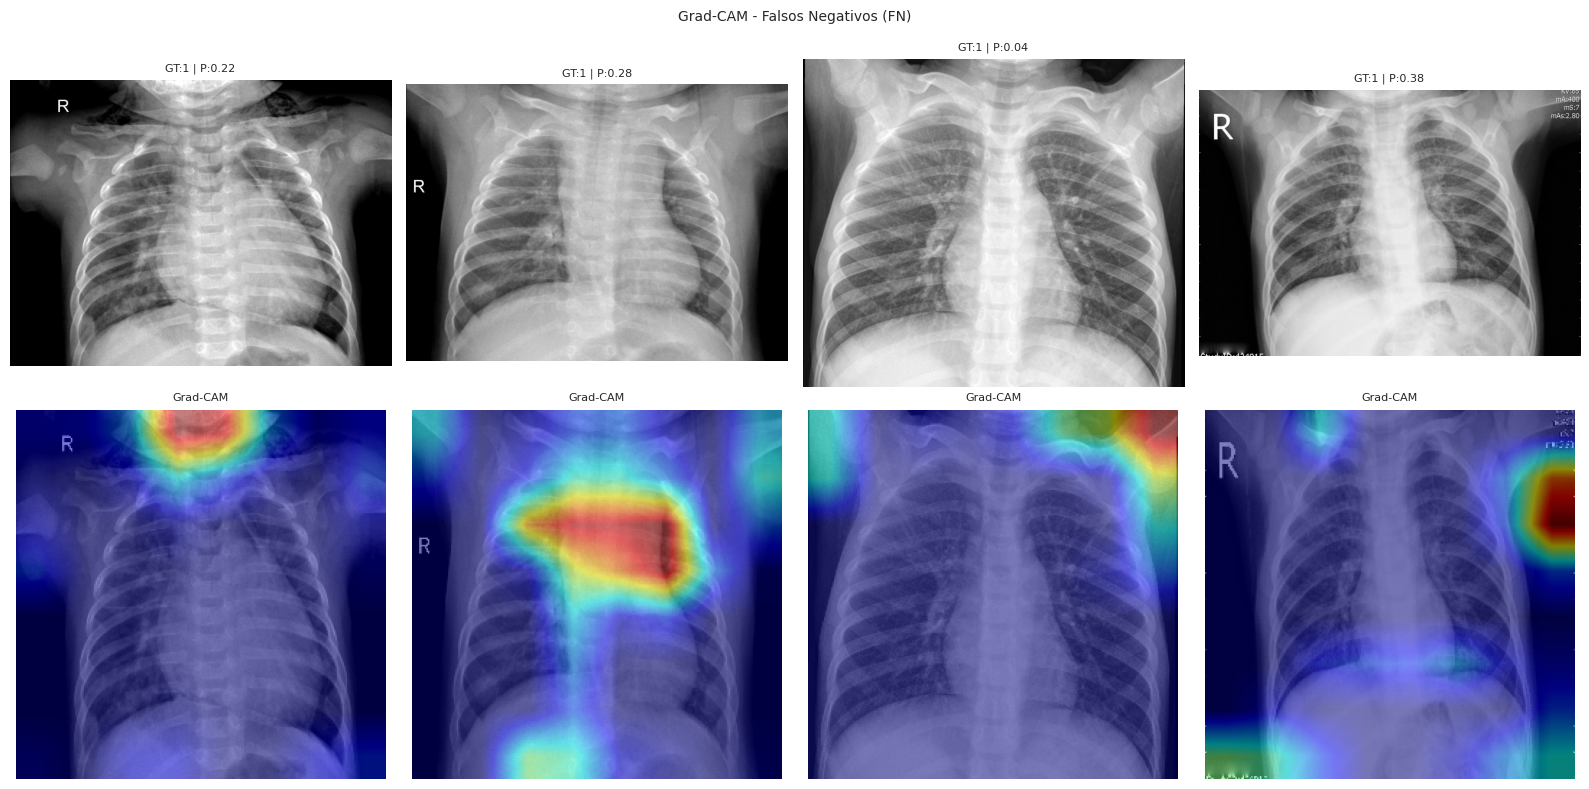

In [ ]:
def get_last_conv_layer(model):
    return model.conv_head

def run_gradcam_on_samples(model_fold_path, samples_df, n_per_cat=4,
                           model_name=MODEL_NAME, title=''):

    # Carrega o modelo do fold (sem pesos pré-treinados) e aplica checkpoint treinado
    model = build_model(model_name, pretrained=False)
    ckpt  = torch.load(model_fold_path, map_location=DEVICE, weights_only=False)
    model.load_state_dict(ckpt['model_state_dict'])
    model.eval()

    # Define a camada alvo do Grad-CAM (última conv)
    target_layer = [get_last_conv_layer(model)]
    cam = GradCAM(model=model, target_layers=target_layer)

    valid_tf = get_valid_transforms(IMG_SIZE)  # mesmas transforms usadas na validação

    n = min(n_per_cat, len(samples_df))
    if n == 0:
        return

    fig, axes = plt.subplots(2, n, figsize=(4*n, 8))
    if n == 1:
        axes = axes.reshape(2, 1)

    # Amostra aleatória
    for i, (_, row) in enumerate(samples_df.sample(n, random_state=SEED).iterrows()):
        img_gray = cv2.imread(row['filepath'], cv2.IMREAD_GRAYSCALE)
        img_rgb  = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)

        # Pré-processa e envia para o device
        input_t = valid_tf(image=img_rgb)['image'].unsqueeze(0).to(DEVICE)

        # Grad-CAM para a saída da classe positiva (logit do índice 0)
        target = [BinaryClassifierOutputTarget(0)]
        mask   = cam(input_tensor=input_t, targets=target)[0]

        # Ajusta dimensões para sobrepor
        img_display = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
        img_show = img_display.astype(np.float32) / 255.0
        cam_img  = show_cam_on_image(img_show, mask, use_rgb=True)

        # Linha 1: imagem original
        axes[0, i].imshow(img_gray, cmap='gray')
        axes[0, i].set_title(f"GT:{int(row['label'])} | P:{row['oof_prob']:.2f}", fontsize=8)
        axes[0, i].axis('off')

        # Linha 2: heatmap Grad-CAM
        axes[1, i].imshow(cam_img)
        axes[1, i].set_title('Grad-CAM', fontsize=8)
        axes[1, i].axis('off')

    plt.suptitle(title, fontsize=10)
    plt.tight_layout()
    plt.show()


# Usa um checkpoint de um fold
fold0_path = MODELS_DIR / f'{MODEL_NAME}_fold0_best.pth'

run_gradcam_on_samples(fold0_path, TP_df, title='Grad-CAM - Verdadeiros Positivos (TP)')
run_gradcam_on_samples(fold0_path, TN_df, title='Grad-CAM - Verdadeiros Negativos (TN)')
run_gradcam_on_samples(fold0_path, FP_df, title='Grad-CAM - Falsos Positivos (FP)')
run_gradcam_on_samples(fold0_path, FN_df, title='Grad-CAM - Falsos Negativos (FN)')

# 16. Inferência com TTA
Vamos agora aplicar a inferência com TTA que explicamos antes.

In [ ]:
def load_fold_model(fold, model_name, device=DEVICE):
    # Carrega o checkpoint best do fold e retorna o modelo pronto para inferência
    model = build_model(model_name, pretrained=False)
    path  = MODELS_DIR / f'{model_name}_fold{fold}_best.pth'
    ckpt  = torch.load(path, map_location=device, weights_only=False)
    model.load_state_dict(ckpt['model_state_dict'])
    model.eval()  # modo eval desativa dropout e fixa batchnorm
    return model


def predict_tta(model, df, tta_transforms, batch_size=BATCH_SIZE,
                num_workers=NUM_WORKERS, device=DEVICE):
    # Predição com TTA: calcula probabilidades para cada transform e faz média.
    all_ids, all_probs_stack = None, []

    # Itera sobre as variações de teste (original + flips)
    for tf in tta_transforms:
        ds = CXRDataset(df, transforms=tf, train=False)
        ld = DataLoader(ds, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=True)

        ids_list, probs_list = [], []

        with torch.no_grad():  # inferência sem gradiente
            for imgs, ids in ld:
                imgs  = imgs.to(device)
                logits = model(imgs).squeeze(1)
                probs  = torch.sigmoid(logits).cpu().numpy()  # logits -> prob

                probs_list.append(probs)
                ids_list.extend(ids)

        if all_ids is None:
            all_ids = ids_list

        # Empilha as probabilidades desta TTA
        all_probs_stack.append(np.concatenate(probs_list))

    # Média das probabilidades ao longo das TTAs
    return np.array(all_ids), np.stack(all_probs_stack).mean(axis=0)


# Ensemble: média ponderada dos folds do mesmo modelo
auc_weights = np.array(fold_aucs)
auc_weights = auc_weights / auc_weights.sum()  # normaliza para somar 1

all_test_probs = []
ids_ref = None

print("Gerando predições de teste com TTA...")

for fold in range(N_FOLDS):
    model = load_fold_model(fold, MODEL_NAME)

    # Predição do fold no teste usando TTA
    ids, probs = predict_tta(
        model,
        test_df.reset_index(drop=True),
        TTA_TRANSFORMS
    )

    if ids_ref is None:
        ids_ref = ids

    # Peso do fold baseado no seu desempenho de validação
    w = auc_weights[fold]
    all_test_probs.append(probs * w)

    print(f"  {MODEL_NAME} fold {fold}: w={w:.3f} | prob mean={probs.mean():.4f}")
    del model # pra liberar memória

# Combina os folds (soma das probabilidades ponderadas)
ensemble_probs = np.stack(all_test_probs).sum(axis=0)

print(f"\nEnsemble probs: min={ensemble_probs.min():.4f} | "
      f"max={ensemble_probs.max():.4f} | mean={ensemble_probs.mean():.4f}")

Gerando predições de teste com TTA...
  tf_efficientnet_b0_ns fold 0: w=0.200 | prob mean=0.6884
  tf_efficientnet_b0_ns fold 1: w=0.200 | prob mean=0.7118
  tf_efficientnet_b0_ns fold 2: w=0.200 | prob mean=0.7812
  tf_efficientnet_b0_ns fold 3: w=0.200 | prob mean=0.7899
  tf_efficientnet_b0_ns fold 4: w=0.200 | prob mean=0.7038

Ensemble probs: min=0.0003 | max=1.0000 | mean=0.7350


# 17. Geração do arquivo de submissão

submission.csv salvo.


id     label
0  img_0001.jpeg  0.458165
1  img_0002.jpeg  0.766639
2  img_0003.jpeg  0.996115
3  img_0004.jpeg  0.086764
4  img_0005.jpeg  0.249893
5  img_0006.jpeg  0.347110
6  img_0007.jpeg  0.058652
7  img_0008.jpeg  0.001440
8  img_0009.jpeg  0.132203
9  img_0010.jpeg  0.477945

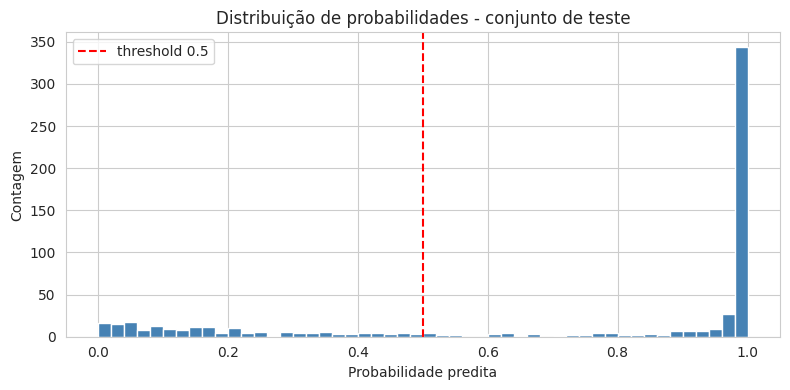


Predições > 0.5 (PNEUMONIA): 444 / 624
Predições <= 0.5 (NORMAL):    180 / 624


In [ ]:
submission_df = pd.DataFrame({'id': ids_ref, 'label': ensemble_probs})
submission_df.to_csv('submission.csv', index=False)
print("submission.csv salvo.")
display(submission_df.head(10))

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(ensemble_probs, bins=50, color='steelblue', edgecolor='white')
ax.axvline(0.5, color='red', ls='--', label='threshold 0.5')
ax.set_xlabel('Probabilidade predita'); ax.set_ylabel('Contagem')
ax.set_title('Distribuição de probabilidades - conjunto de teste')
ax.legend(); plt.tight_layout(); plt.show()

print(f"\nPredições > 0.5 (PNEUMONIA): {(ensemble_probs > 0.5).sum()} / {len(ensemble_probs)}")
print(f"Predições <= 0.5 (NORMAL):    {(ensemble_probs <= 0.5).sum()} / {len(ensemble_probs)}")